In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import os
from module import Model_Training
import logging
tf.get_logger().setLevel(logging.ERROR)
tf.config.experimental.enable_tensor_float_32_execution(False)

2023-02-28 01:25:03.916973: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 01:25:05.053677: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/CUPTI/lib64:/home/jj/miniconda3/envs/tf/lib/
2023-02-28 01:25:05.053826: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LI

In [2]:
# full_img_path = '/mnt/d/Datasets/CBIS_DDSM/full/'
roi_img_path = '/mnt/d/CBIS-DDSM/new_ROI/augmented/'
img_height = 300
img_width = 300
batch_size = 16
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
def datasets(roi_img_path):
  train_ds = tf.keras.utils.image_dataset_from_directory(
    roi_img_path+'train/',
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)
  val_ds = tf.keras.utils.image_dataset_from_directory(
    roi_img_path+'val/',
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)
  train = train_ds.prefetch(AUTOTUNE)
  val = val_ds.prefetch(AUTOTUNE)
  test_ds = tf.keras.utils.image_dataset_from_directory(
    roi_img_path+'test/',
    label_mode="categorical",
    shuffle=False,
    image_size=(img_height, img_width),
    batch_size=batch_size)
  # test = test_ds.prefetch(AUTOTUNE)
  return train, val,test_ds


In [4]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        print(
            f' Epoch {epoch}: accuracy={logs["categorical_accuracy"]:.4f}, loss={logs["loss"]:.4f}, '+
            f'val_accuracy={logs["val_categorical_accuracy"]:.4f}, val_loss={logs["val_loss"]:.4f}, '+
            f' - lr={lr:.7f}')

# Normalisation only

In [5]:
train,val,test = datasets('/mnt/d/CBIS-DDSM/new_ROI/augmented/')
model, inception_dense_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=20,
    patience=False,
    Earlystop=10,
    augmentation = True,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log='/home/jj/FYP/log/norm_CBIS_DDSM/InceptionV3_CBIS_DDSM_dense.csv',
    load_weights = False,
    save_weights = '/home/jj/FYP/Checkpoint/norm_CBIS_DDSM/Dense/best_model',
    learning_rate=1e-5,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

Found 3216 files belonging to 2 classes.
Found 220 files belonging to 2 classes.
Found 322 files belonging to 2 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
      

2023-02-28 01:25:24.452934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-28 01:25:26.113803: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-02-28 01:25:26.563540: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f995c01bb60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-28 01:25:26.563567: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capabi

201/201 [==============================] - 49s 203ms/step - loss: 2.0660 - categorical_accuracy: 0.5252 - recall_8: 0.3999 - recall_9: 0.6386 - val_loss: 2.0403 - val_categorical_accuracy: 0.5318 - val_recall_8: 0.4141 - val_recall_9: 0.6281
Epoch 2/2
201/201 [==============================] - 40s 197ms/step - loss: 2.0202 - categorical_accuracy: 0.5712 - recall_8: 0.5399 - recall_9: 0.5995 - val_loss: 2.0077 - val_categorical_accuracy: 0.5364 - val_recall_8: 0.5556 - val_recall_9: 0.5207
Epoch 3/3
201/201 [==============================] - 40s 198ms/step - loss: 1.9714 - categorical_accuracy: 0.6070 - recall_8: 0.6734 - recall_9: 0.5468 - val_loss: 1.9806 - val_categorical_accuracy: 0.5273 - val_recall_8: 0.9293 - val_recall_9: 0.1983
Epoch 4/4
201/201 [==============================] - 39s 194ms/step - loss: 1.9176 - categorical_accuracy: 0.6178 - recall_8: 0.6976 - recall_9: 0.5456 - val_loss: 1.9460 - val_categorical_accuracy: 0.5273 - val_recall_8: 0.9798 - val_recall_9: 0.1570
Ep

## Fine Tune

In [6]:
model, inception_fine_tune_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=300,
    patience=5,
    Earlystop=20,
    augmentation = True,
    trainable_layers = 63,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log='/home/jj/FYP/log/norm_CBIS_DDSM/InceptionV3_CBIS_DDSM_Fine_Tune.csv',
    load_weights = '/home/jj/FYP/Checkpoint/norm_CBIS_DDSM/Dense/best_model',
    save_weights = '/home/jj/FYP/Checkpoint/norm_CBIS_DDSM/Fine_Tune/best_model',
    learning_rate=1e-5,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0   

## Figures

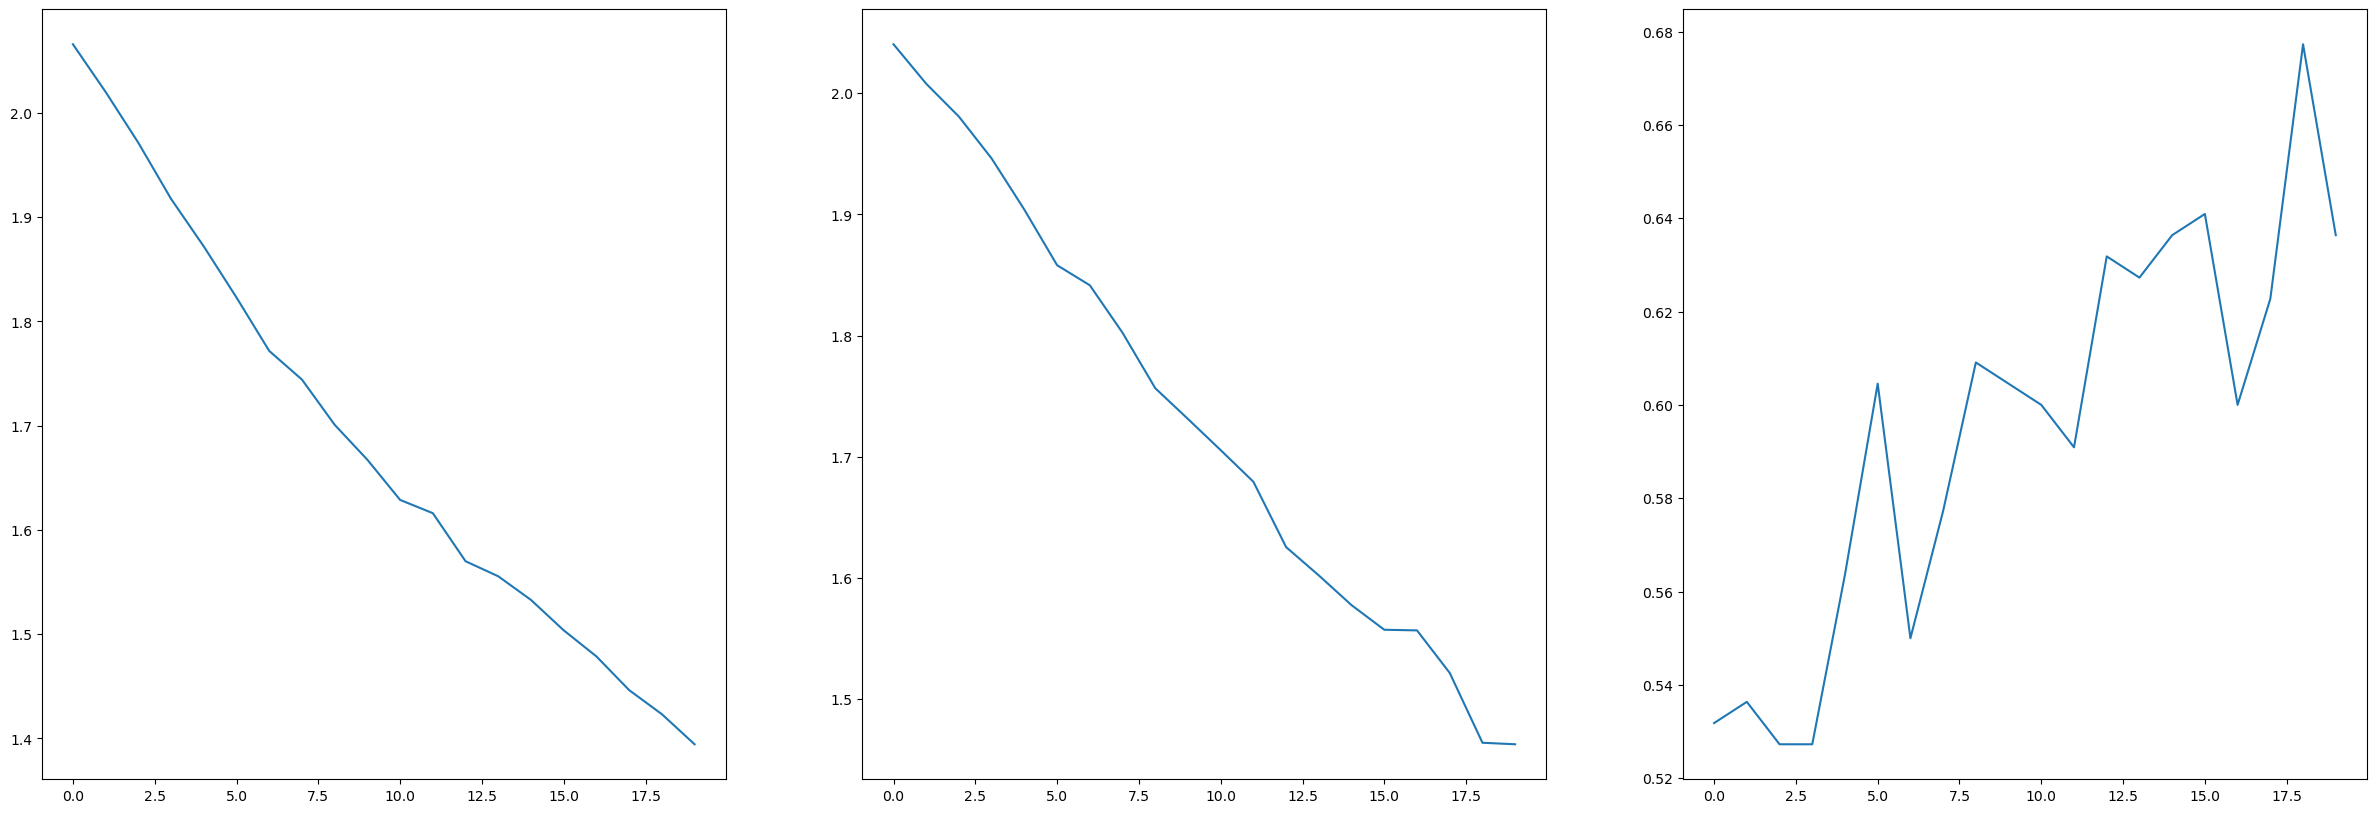

In [7]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(inception_dense_history['train_loss'])
plt.subplot(132)
plt.plot(inception_dense_history['val_loss'])
plt.subplot(133)
plt.plot(inception_dense_history['val_acc'])

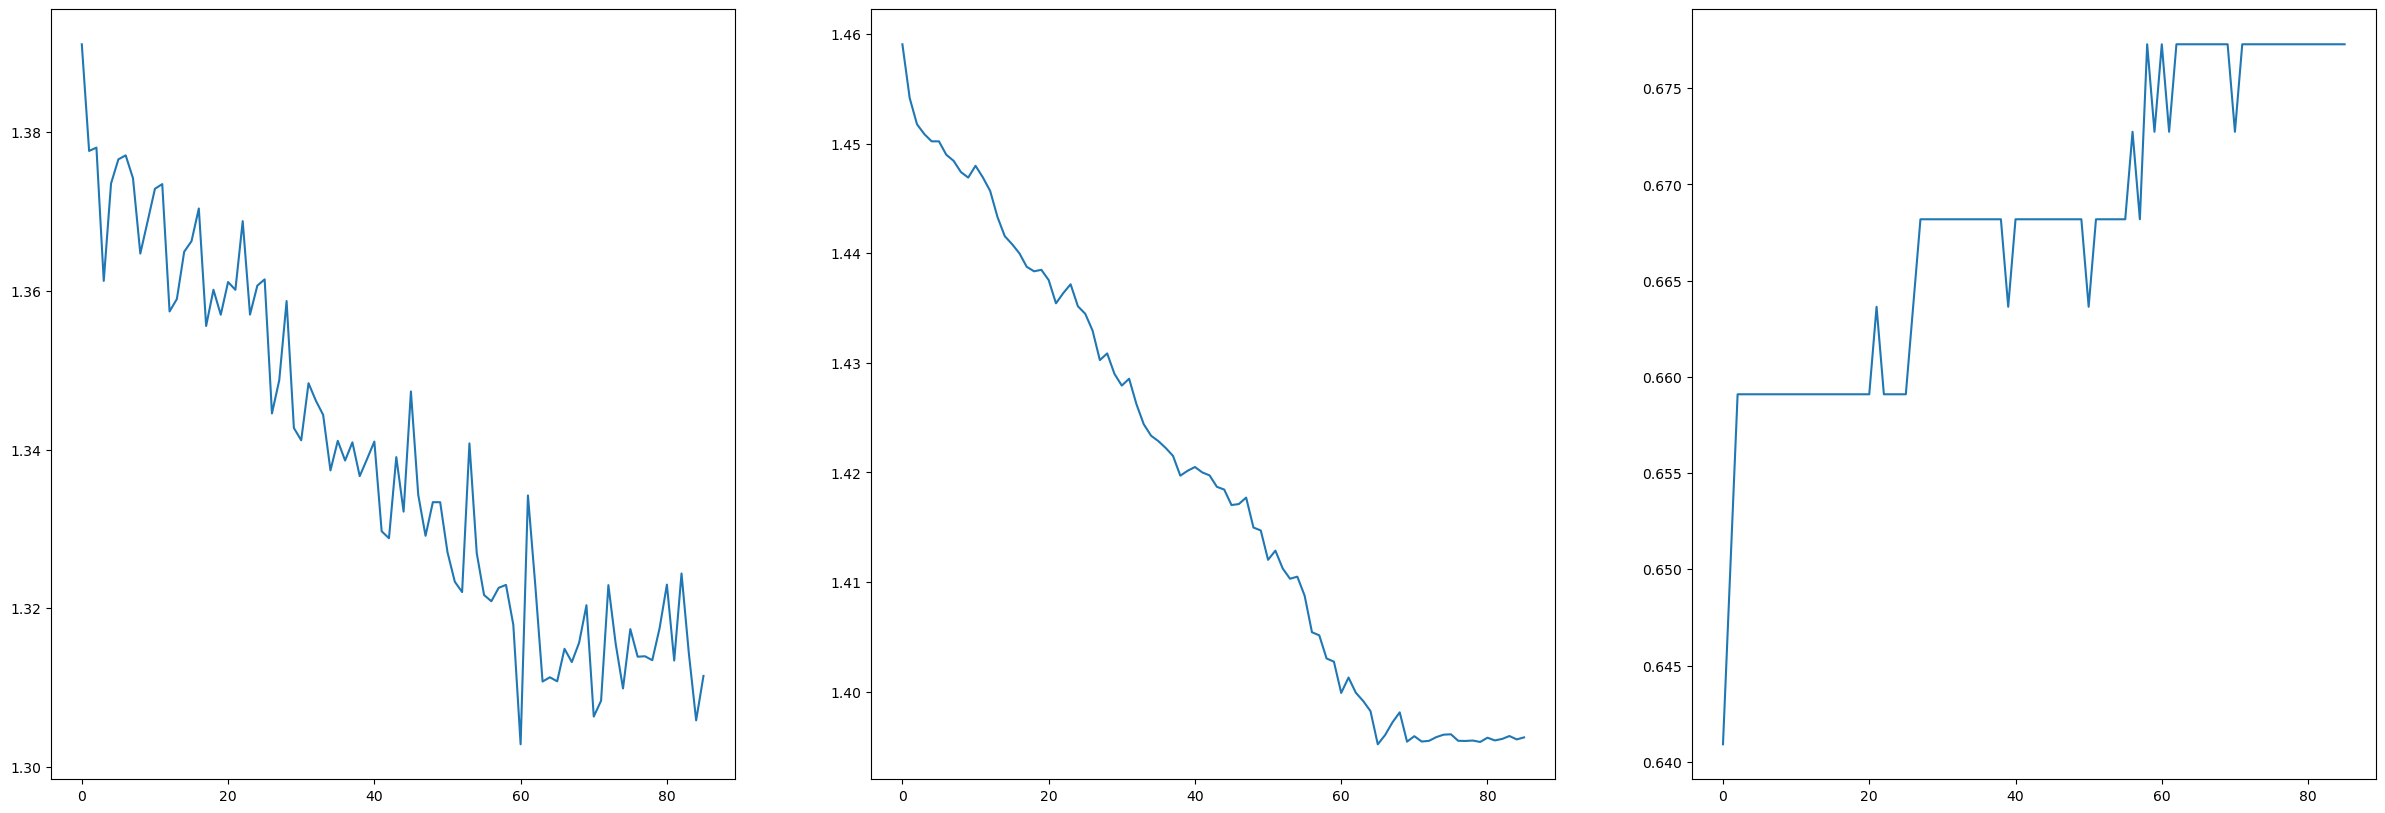

In [8]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(inception_fine_tune_history['train_loss'])
plt.subplot(132)
plt.plot(inception_fine_tune_history['val_loss'])
plt.subplot(133)
plt.plot(inception_fine_tune_history['val_acc'])


## Test

In [9]:
metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)]
# train,val,test = datasets('/mnt/d/CBIS-DDSM/new_ROI/augmented/')
# model = Model_Training.build_model('inceptionv3',trainable_layers=False)

In [10]:
model.load_weights('/home/jj/FYP/Checkpoint/norm_CBIS_DDSM/Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

21/21 [==============================] - 13s 440ms/step - loss: 1.4053 - categorical_accuracy: 0.7112 - precision: 0.6833 - precision_1: 0.7927


In [11]:
misclassified = Model_Training.store_misclassified(model,test,
'/mnt/d/CBIS-DDSM/new_ROI/augmented/misclassified/')
tf.keras.backend.clear_session()

21/21 [==============================] - 2s 40ms/step


Image without padding, normalisation used

21/21 [==============================] - 2s 40ms/step - loss: 0.8528 - categorical_accuracy: 0.7019 - precision_2: 0.7778 - precision_3: 0.6331


# Padding + normalisation

## Initialising

In [20]:
weights = '/home/jj/FYP/Checkpoint/pad_norm_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/pad_norm_CBIS_DDSM/'
train,val,test = datasets('/mnt/d/CBIS-DDSM/new_ROI/withpad/')
model, effnetv2m_dense_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=20,
    patience=False,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=5e-5,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

NotFoundError: Could not find directory /mnt/d/CBIS-DDSM/new_ROI/withpad/train/

## Fine Tuning

In [15]:
model, effnetv2m_fine_tune_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=300,
    patience=5,
    Earlystop=20,
    augmentation = True,
    trainable_layers = 63,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0   

## Figures

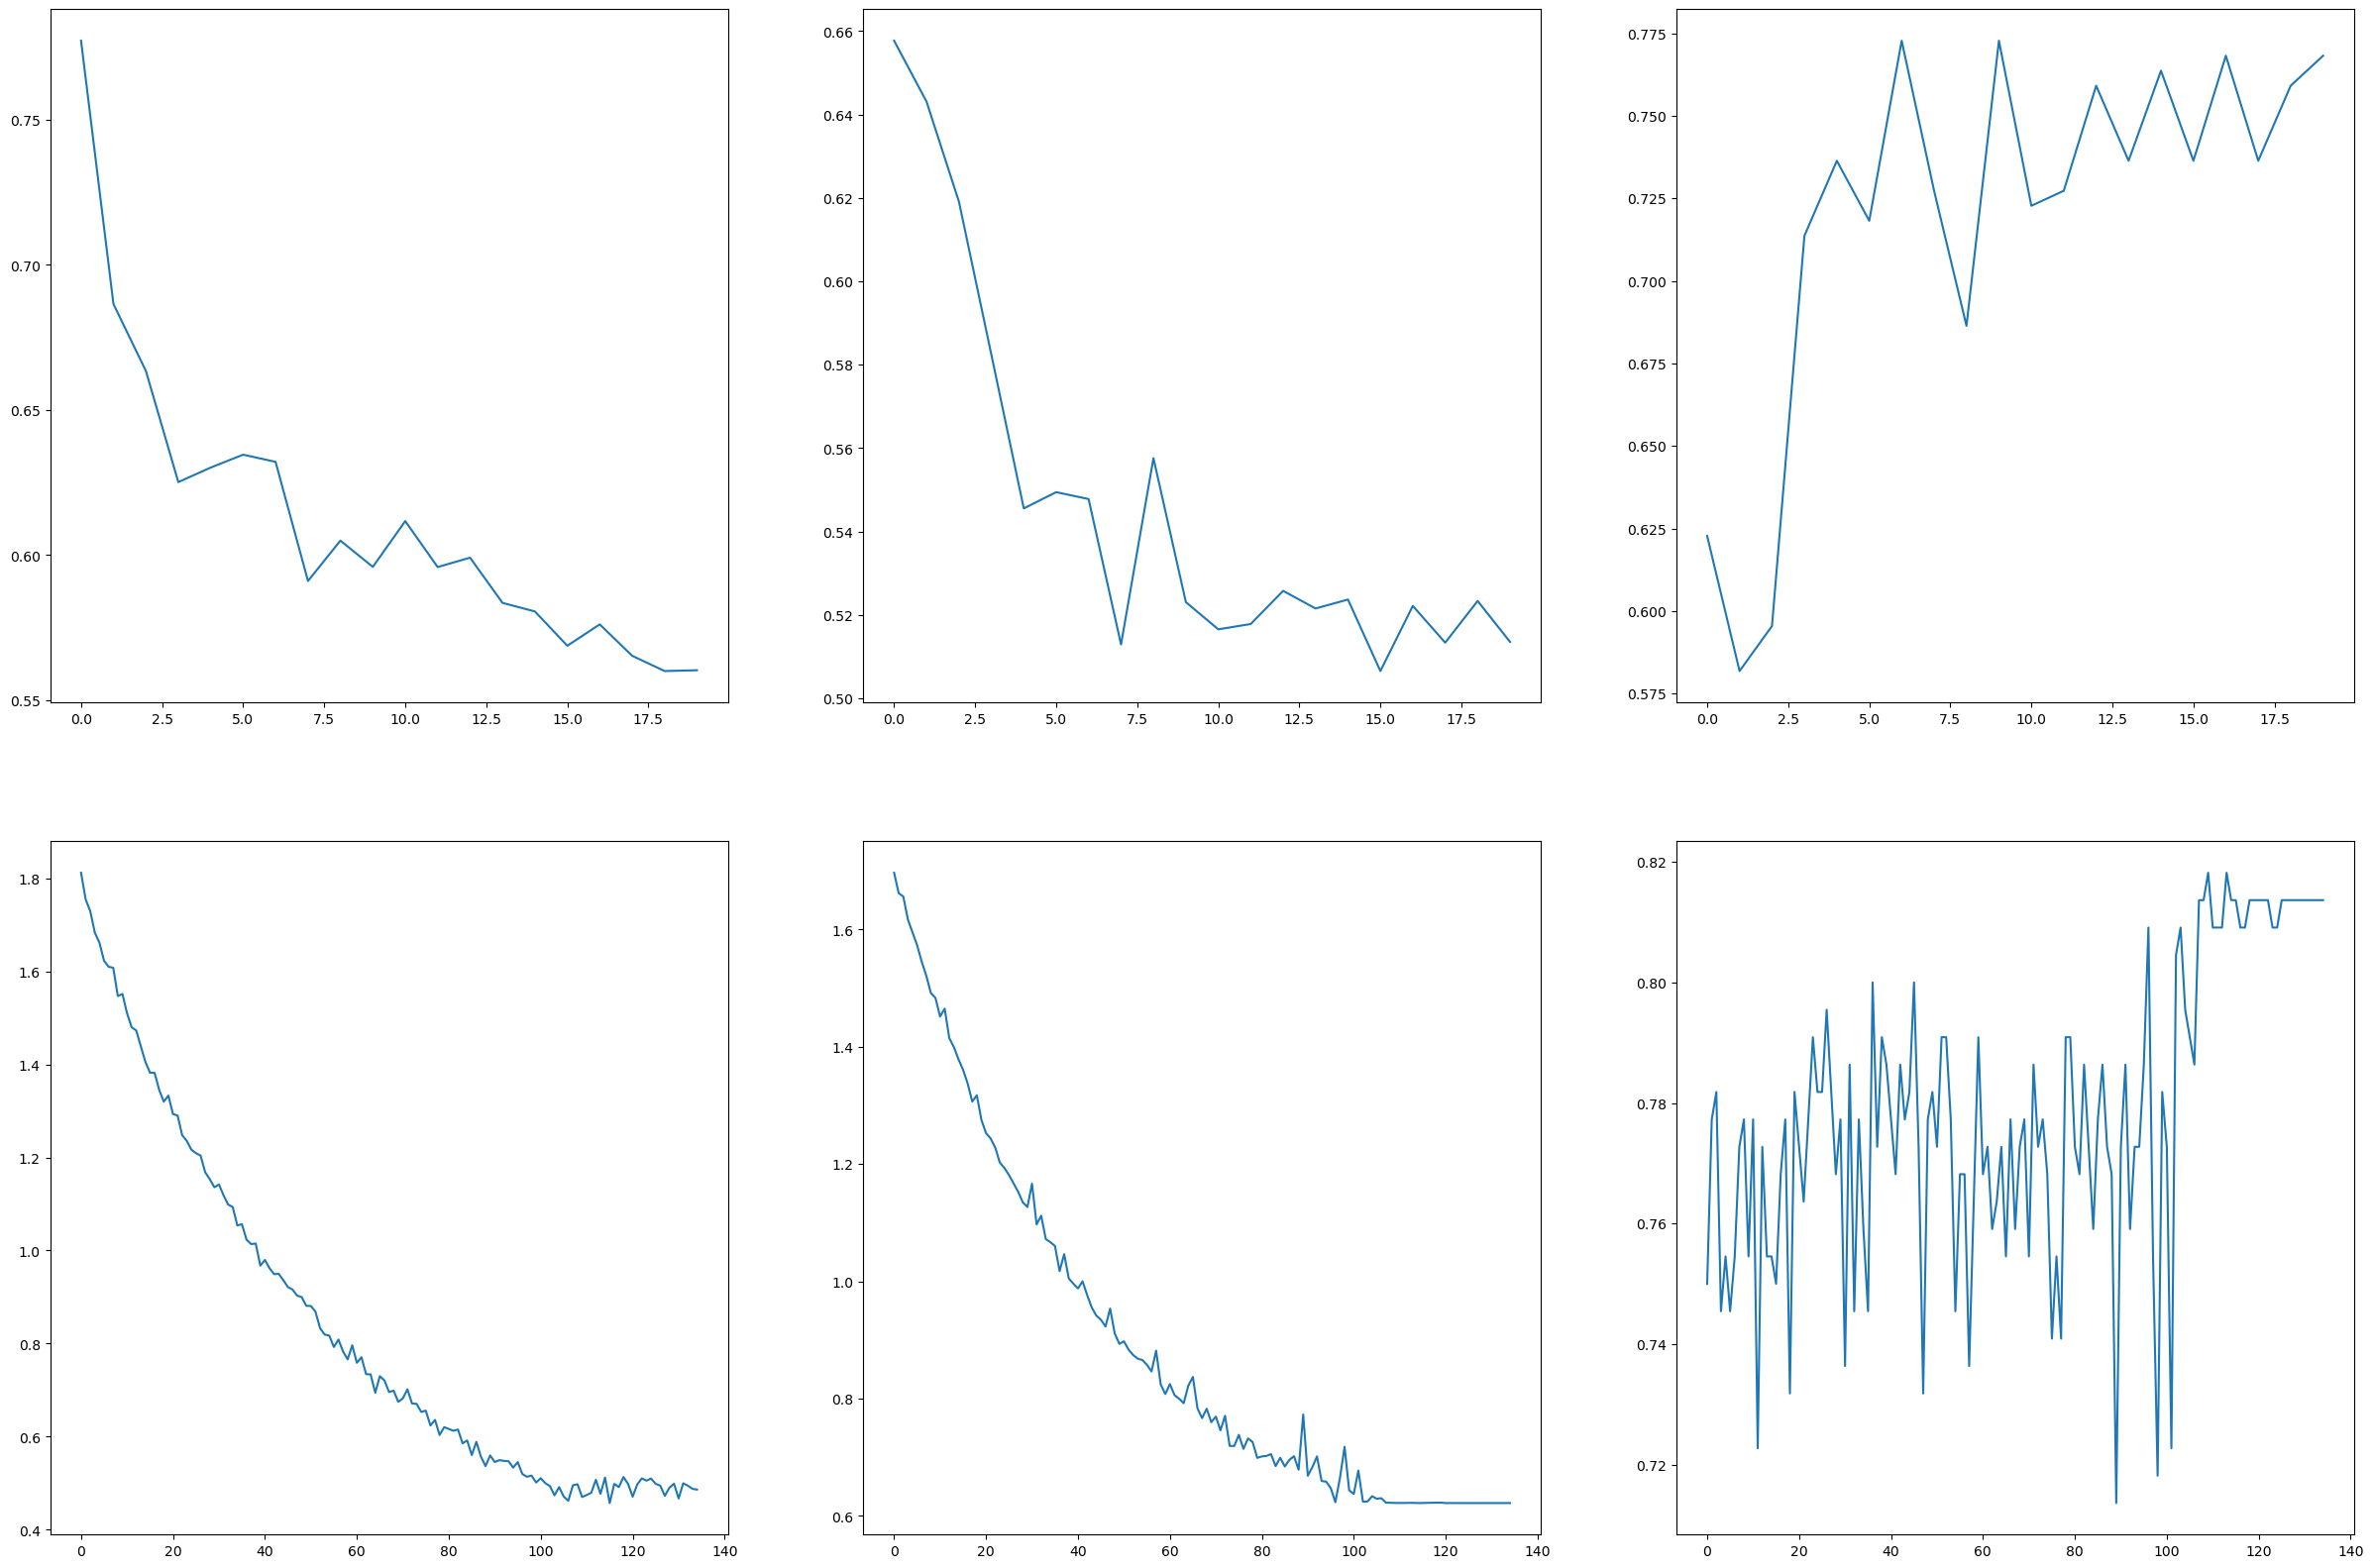

In [16]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(effnetv2m_dense_history['train_loss'])
plt.subplot(232)
plt.plot(effnetv2m_dense_history['val_loss'])
plt.subplot(233)
plt.plot(effnetv2m_dense_history['val_acc'])
plt.subplot(234)
plt.plot(effnetv2m_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(effnetv2m_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(effnetv2m_fine_tune_history['val_acc'])

## Test

In [17]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

21/21 [==============================] - 10s 238ms/step - loss: 0.7600 - categorical_accuracy: 0.7267 - precision_2: 0.7853 - precision_3: 0.6667


In [ ]:
misclassified = Model_Training.store_misclassified(model,test,
'/mnt/d/CBIS-DDSM/new_ROI/augmented/misclassified/')
tf.keras.backend.clear_session()

# PADDIng, normalisation and CLAHE

## Initialising

In [5]:
weights = '/home/jj/FYP/Checkpoint/pad_norm_clahe_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/pad_norm_clahe_CBIS_DDSM/'
train,val,test = datasets('/mnt/d/CBIS-DDSM/new_ROI/withpad_clahe/')
model, resnet_dense_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = False,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.L2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-5,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Found 845 files belonging to 2 classes.
Found 220 files belonging to 2 classes.
Found 322 files belonging to 2 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
       

2023-02-27 10:19:54.361953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-27 10:19:56.689729: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-02-27 10:19:57.414128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-27 10:19:57.436653: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1b9399e0 initialized for platform CUDA (this does not guarantee tha

53/53 [==============================] - 12s 96ms/step - loss: 2.2158 - categorical_accuracy: 0.5799 - precision: 0.5576 - precision_1: 0.5935 - val_loss: 2.1231 - val_categorical_accuracy: 0.6136 - val_precision: 0.7333 - val_precision_1: 0.5947
Epoch 2/2
53/53 [==============================] - 3s 54ms/step - loss: 2.0907 - categorical_accuracy: 0.7065 - precision: 0.7081 - precision_1: 0.7054 - val_loss: 2.0390 - val_categorical_accuracy: 0.7136 - val_precision: 0.6957 - val_precision_1: 0.7266
Epoch 3/3
53/53 [==============================] - 3s 54ms/step - loss: 2.0252 - categorical_accuracy: 0.7314 - precision: 0.7165 - precision_1: 0.7435 - val_loss: 2.0314 - val_categorical_accuracy: 0.7500 - val_precision: 0.6897 - val_precision_1: 0.8173
Epoch 4/4
53/53 [==============================] - 3s 54ms/step - loss: 1.9073 - categorical_accuracy: 0.8095 - precision: 0.8080 - precision_1: 0.8106 - val_loss: 2.0223 - val_categorical_accuracy: 0.7318 - val_precision: 0.6961 - val_preci

## Fine Tune

In [6]:
model, resnet_fine_tune_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=300,
    patience=5,
    Earlystop=20,
    augmentation = True,
    trainable_layers = 63,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0   

## Figures

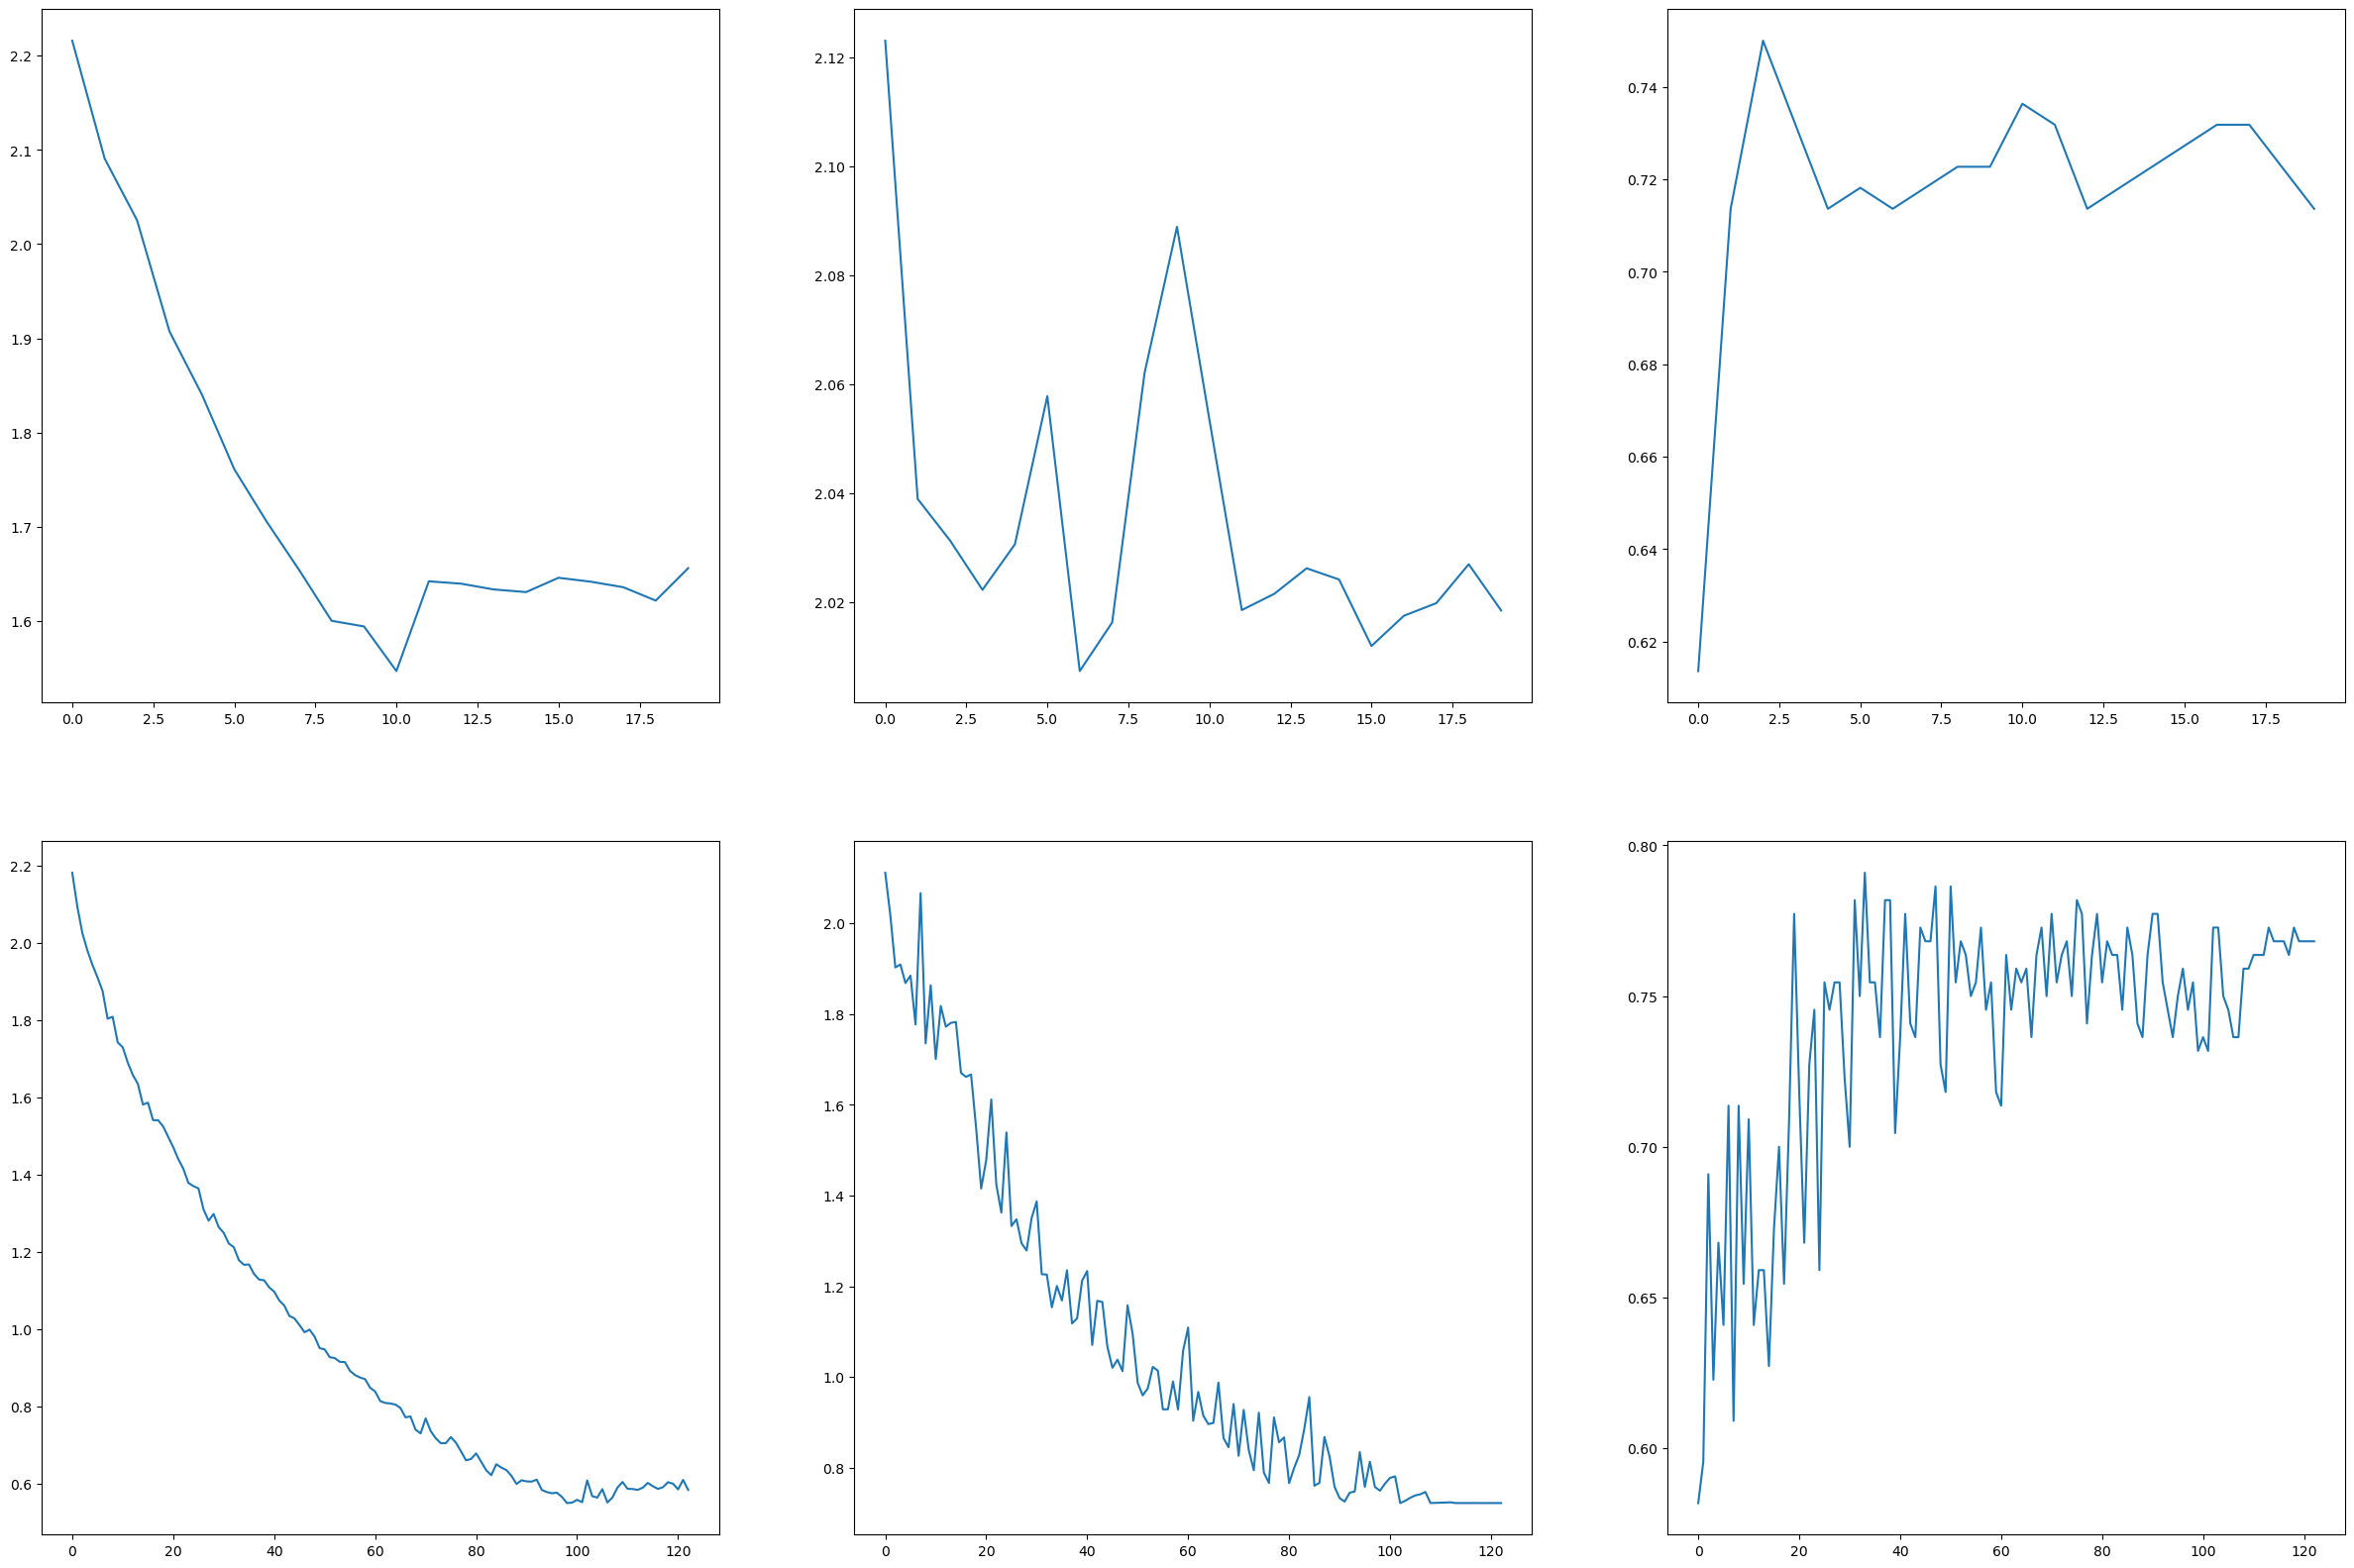

In [7]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(resnet_dense_history['train_loss'])
plt.subplot(232)
plt.plot(resnet_dense_history['val_loss'])
plt.subplot(233)
plt.plot(resnet_dense_history['val_acc'])
plt.subplot(234)
plt.plot(resnet_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(resnet_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(resnet_fine_tune_history['val_acc'])

## Test

In [8]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

21/21 [==============================] - 8s 331ms/step - loss: 0.8969 - categorical_accuracy: 0.6832 - precision_2: 0.7394 - precision_3: 0.6242


In [9]:
misclassified = Model_Training.store_misclassified(model,test,
'/mnt/d/CBIS-DDSM/new_ROI/withpad_clahe/misclassified/')
tf.keras.backend.clear_session()

21/21 [==============================] - 1s 32ms/step


# Originalsize with CLAHE

In [14]:
weights = '/home/jj/FYP/Checkpoint/ogsize_clahe_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/ogsize_clahe_CBIS_DDSM/'
train,val,test = datasets('/mnt/d/CBIS-DDSM/new_ROI/originalsize_clahe/')
model, vgg16_dense_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Found 845 files belonging to 2 classes.
Found 220 files belonging to 2 classes.
Found 322 files belonging to 2 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
       

## Fine Tune

In [15]:

model, vgg16_fine_tune_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=300,
    patience=5,
    Earlystop=20,
    augmentation = True,
    trainable_layers = 63,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0   

## Figures

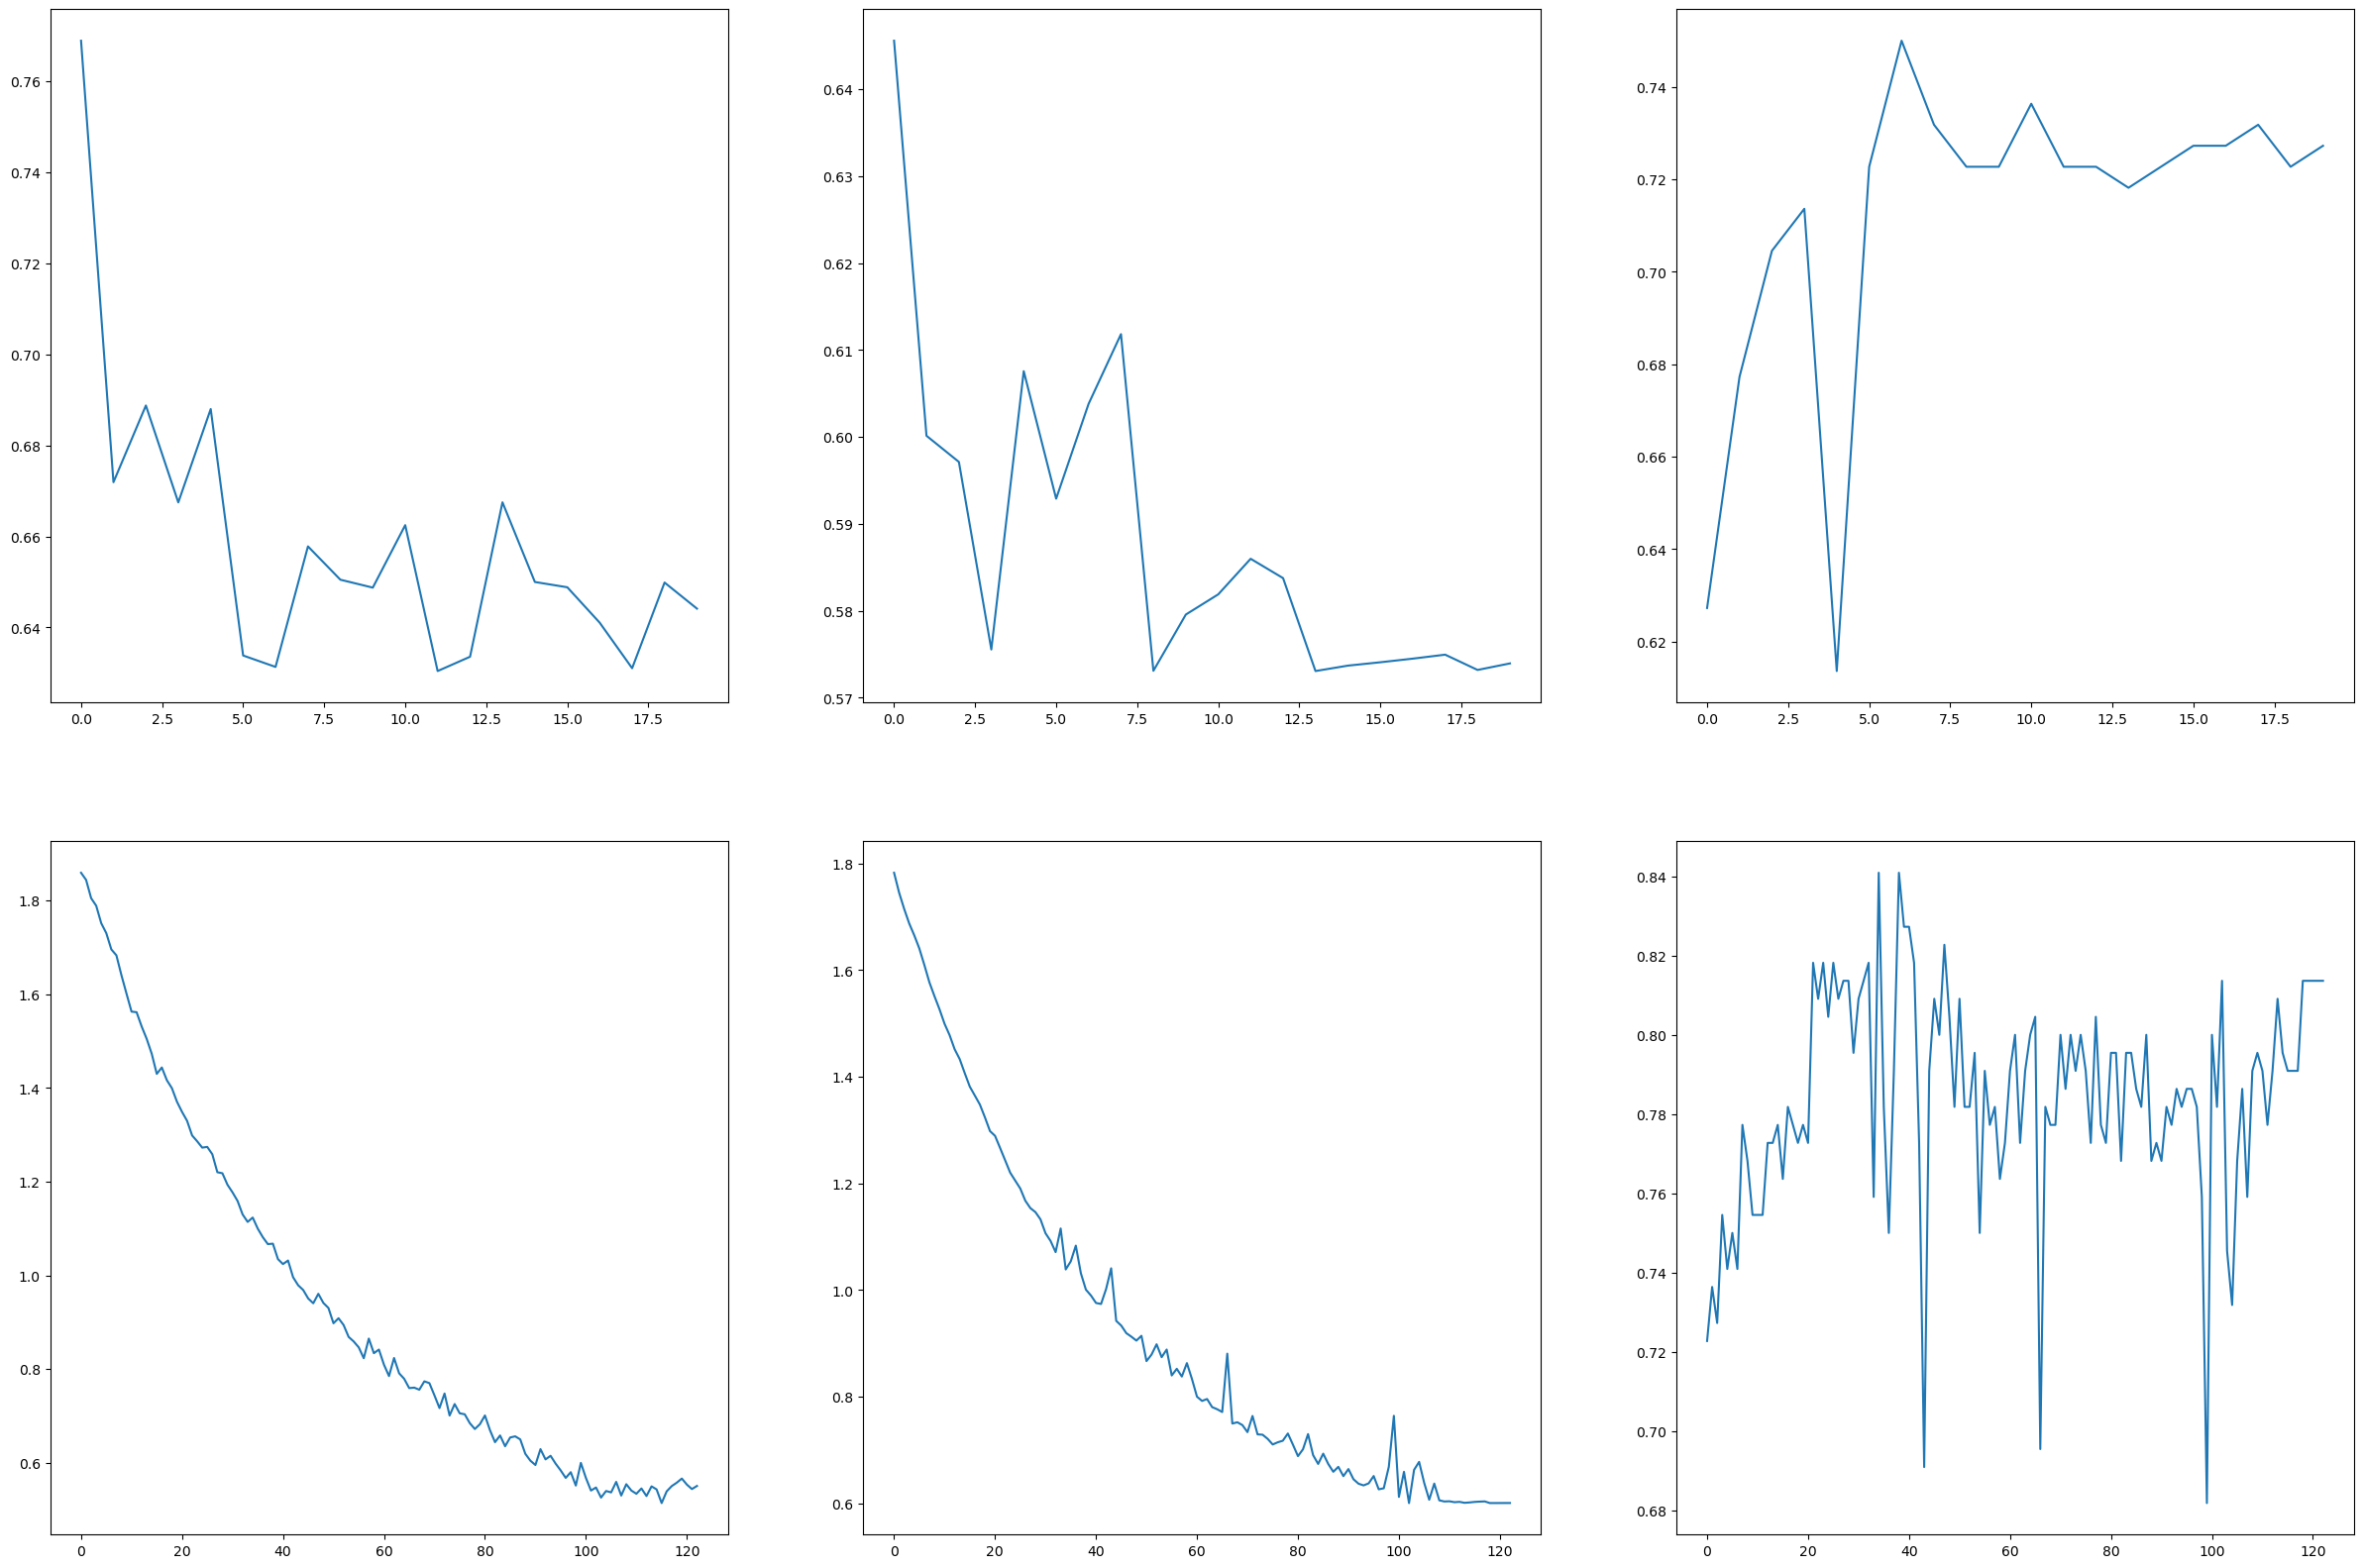

In [16]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(vgg16_dense_history['train_loss'])
plt.subplot(232)
plt.plot(vgg16_dense_history['val_loss'])
plt.subplot(233)
plt.plot(vgg16_dense_history['val_acc'])
plt.subplot(234)
plt.plot(vgg16_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(vgg16_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(vgg16_fine_tune_history['val_acc'])

## Test

In [17]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

21/21 [==============================] - 14s 381ms/step - loss: 0.7695 - categorical_accuracy: 0.7050 - precision_2: 0.7500 - precision_3: 0.6533


# Preprocessed images

In [6]:
weights = '/home/jj/FYP/Checkpoint/CBIS_DDSM_Patch/'
train_log = '/home/jj/FYP/log/CBIS_DDSM_Patch/'
train,val,test = datasets('/mnt/d/CBIS_DDSM_Patch/png/')
model, effnet_dense_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=10,
    augmentation = True,
    flatten = 'flatten',
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-5,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Found 956 files belonging to 2 classes.
Found 238 files belonging to 2 classes.
Found 362 files belonging to 2 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
       

2023-02-26 00:29:49.063476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-26 00:29:51.101647: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-02-26 00:29:51.807732: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-26 00:29:51.824824: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f326800dbd0 initialized for platform CUDA (this does not guarantee

60/60 [==============================] - 24s 240ms/step - loss: 0.7126 - categorical_accuracy: 0.5335 - recall: 0.4075 - recall_1: 0.6474 - val_loss: 0.6809 - val_categorical_accuracy: 0.5462 - val_recall: 0.3451 - val_recall_1: 0.7280
Epoch 2/2
60/60 [==============================] - 12s 206ms/step - loss: 0.6962 - categorical_accuracy: 0.5366 - recall: 0.3282 - recall_1: 0.7251 - val_loss: 0.6730 - val_categorical_accuracy: 0.5504 - val_recall: 0.0619 - val_recall_1: 0.9920
Epoch 3/3
60/60 [==============================] - 13s 208ms/step - loss: 0.6806 - categorical_accuracy: 0.5795 - recall: 0.3965 - recall_1: 0.7450 - val_loss: 0.6703 - val_categorical_accuracy: 0.5294 - val_recall: 0.0442 - val_recall_1: 0.9680
Epoch 4/4
60/60 [==============================] - 12s 203ms/step - loss: 0.6684 - categorical_accuracy: 0.5743 - recall: 0.3546 - recall_1: 0.7729 - val_loss: 0.6614 - val_categorical_accuracy: 0.5378 - val_recall: 0.0531 - val_recall_1: 0.9760
Epoch 5/5
60/60 [=========

## Fine Tune

In [7]:
model, effnet_fine_tune_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=20,
    augmentation = True,
    flatten = 'flatten',
    trainable_layers = 63,
    # regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0   

## Figures

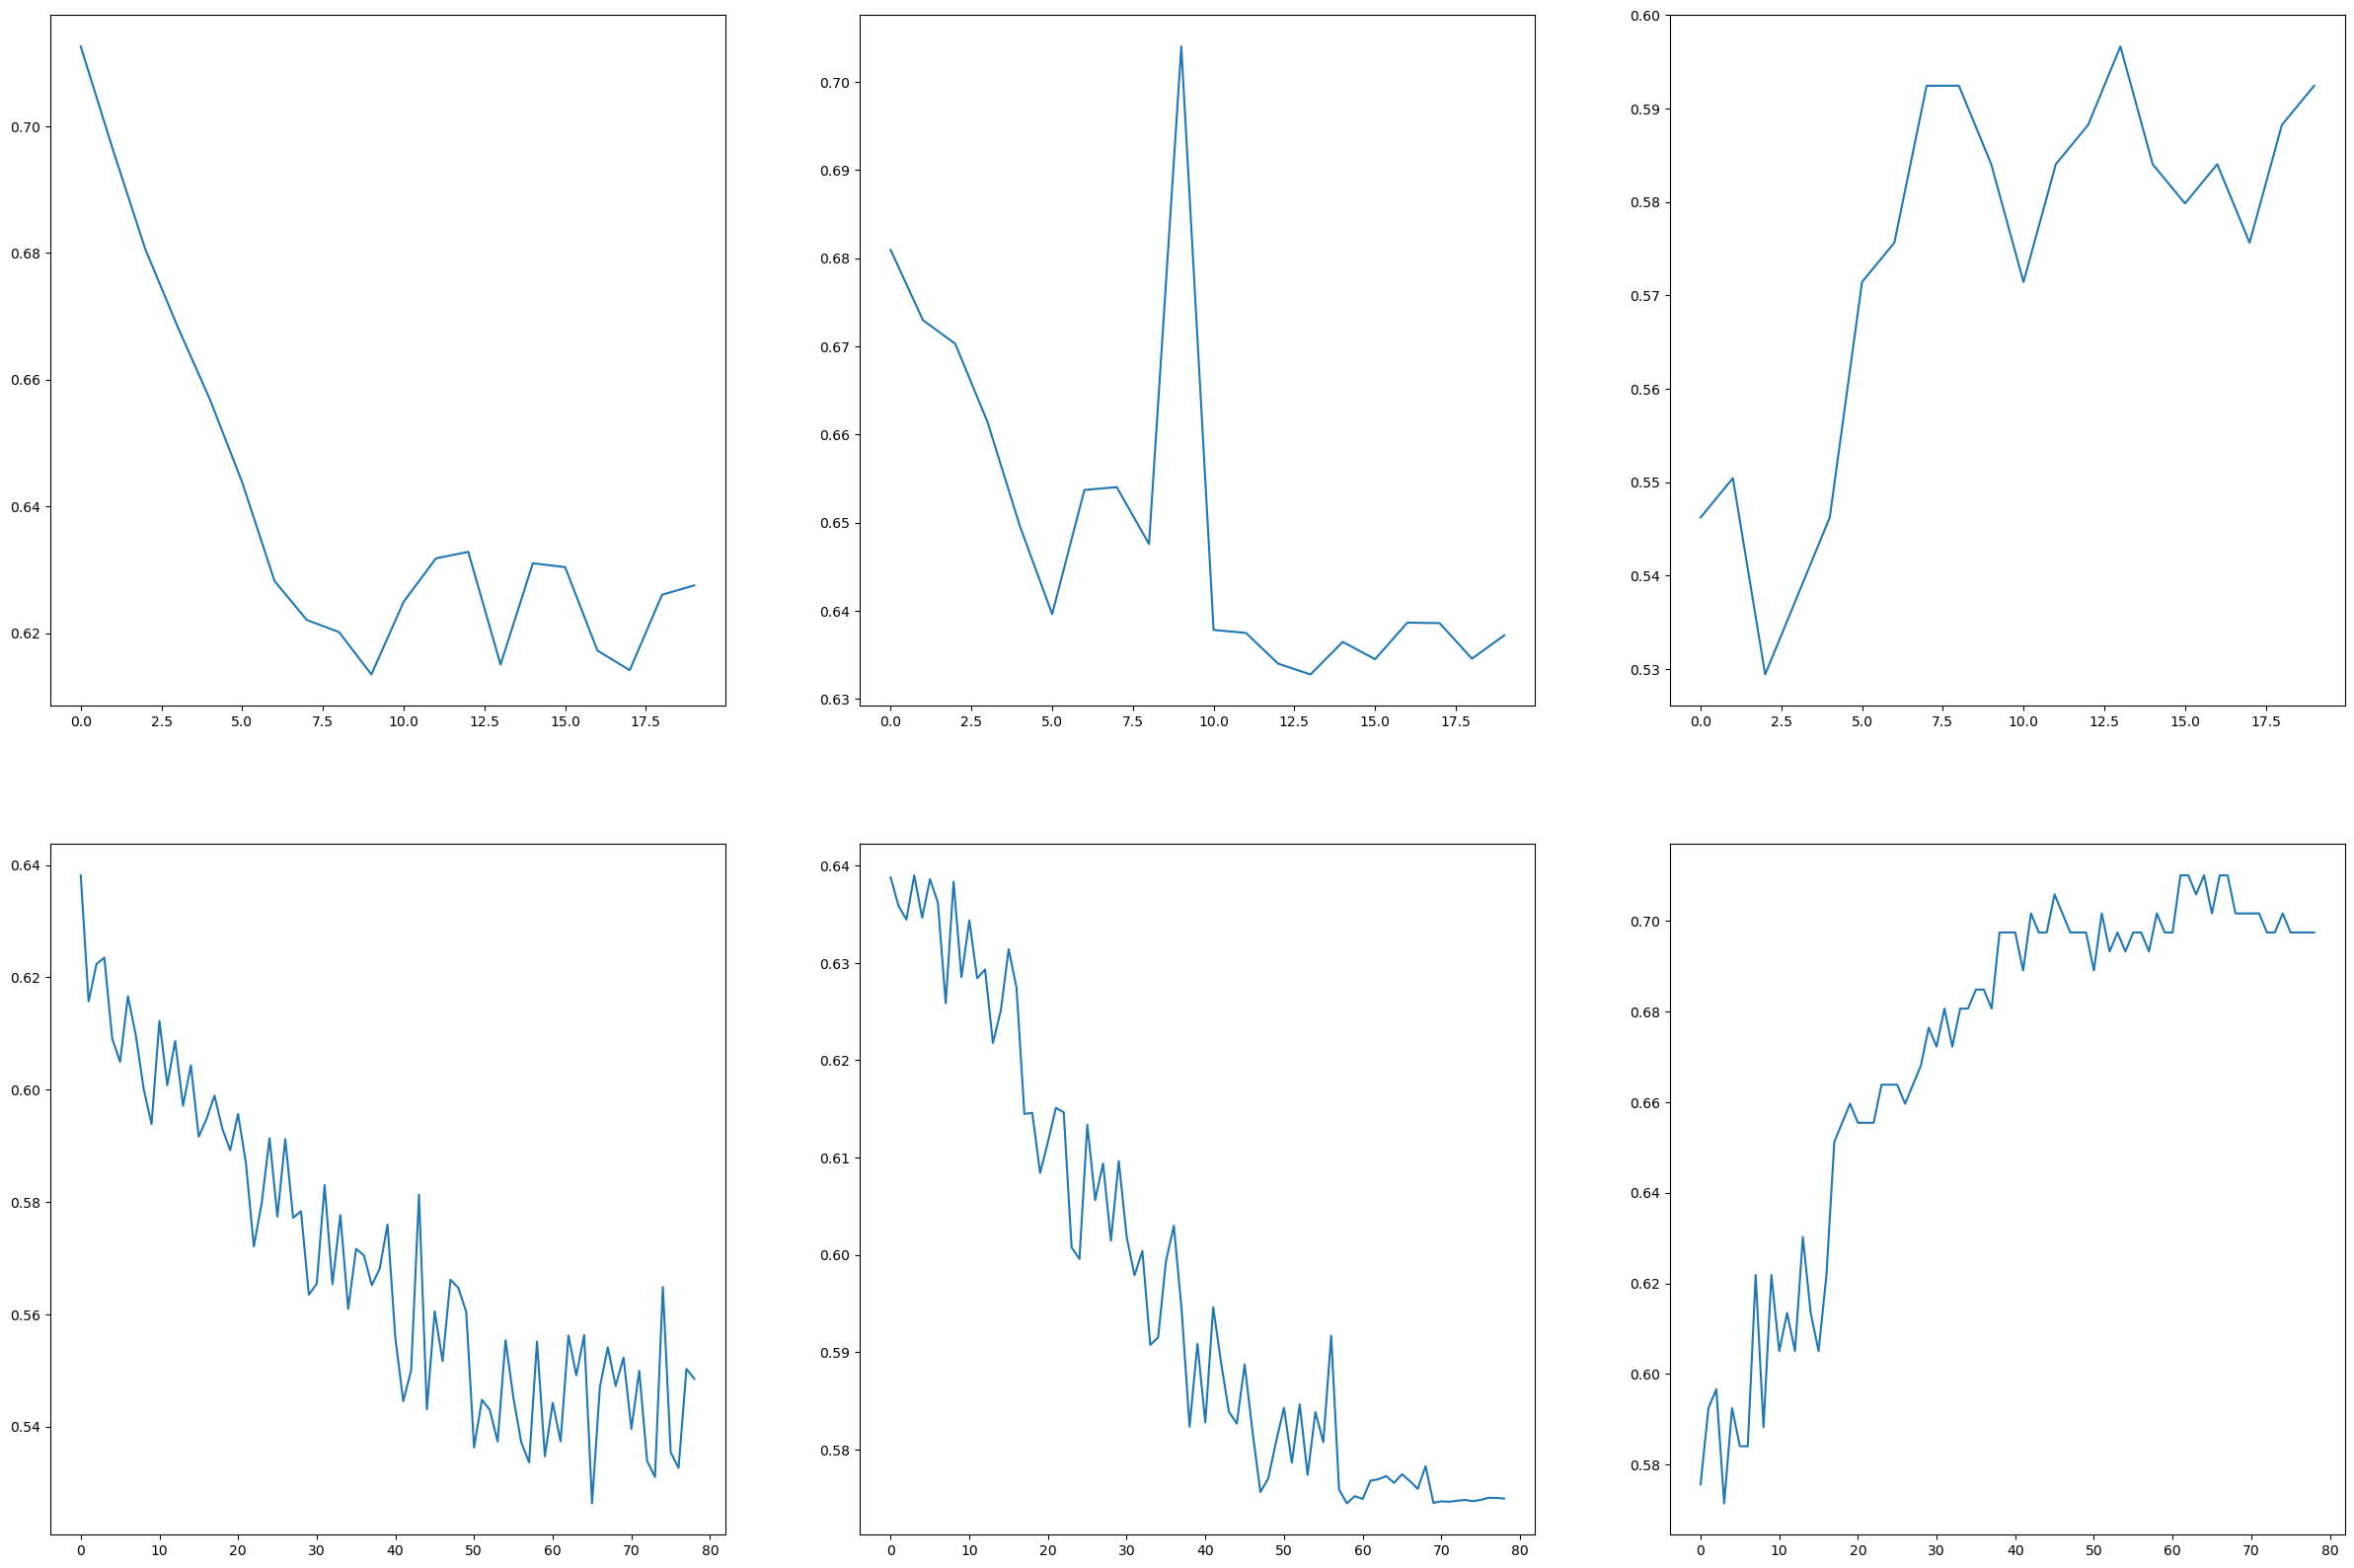

In [10]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(effnet_dense_history['train_loss'])
plt.subplot(232)
plt.plot(effnet_dense_history['val_loss'])
plt.subplot(233)
plt.plot(effnet_dense_history['val_acc'])
plt.subplot(234)
plt.plot(effnet_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(effnet_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(effnet_fine_tune_history['val_acc'])

## Test

In [6]:
model = Model_Training.build_model('inceptionv3',augmentation=False,Flatten='flatten')
train,val,test = datasets('/mnt/d/CBIS_DDSM_Patch/png/')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 100)               131073

In [8]:
weights = '/home/jj/FYP/Checkpoint/CBIS_DDSM_Patch/'

In [13]:
test = tf.keras.preprocessing.image_dataset_from_directory(
    '/mnt/d/CBIS_DDSM_Patch/png/test/',
    batch_size=batch_size,
    label_mode = 'categorical',
    image_size=(300, 300)
)

Found 362 files belonging to 2 classes.


In [14]:

model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

23/23 [==============================] - 2s 40ms/step - loss: 0.6197 - categorical_accuracy: 0.6575 - precision: 0.7455 - precision_1: 0.5838


In [57]:
import numpy as np
labels = ['benign','malignant']
test_predictions = model.predict(test)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_predicted_labels = [labels[i] for i in test_predicted_labels]
test_true_labels = np.concatenate([y for x, y in test], axis=0)
misclassified_indices = []
for i,y in enumerate(test_true_labels):
    if y[1] == 1:
        if test_predicted_labels[i] != 'malignant':
            misclassified_indices.append(i)
    elif y[0] == 1:
        if test_predicted_labels[i] != 'benign':
            misclassified_indices.append(i)
# for x in test_predicted_labels:
    # if x != 
# misclassified_indices = np.where(test_predicted_labels != test_truth)
test_filenames = test.file_paths
misclassified_images = [test_filenames[i] for i in misclassified_indices]

23/23 [==============================] - 1s 47ms/step


In [66]:
import os
import shutil

# directory containing images
# dir_path = 'path/to/directory/containing/images'

# directory to move misclassified images
dest_dir_path = '/mnt/d/CBIS_DDSM_Patch/png/misclassified/'

# list of misclassified image paths
# misclassified_paths = ['path/to/misclassified/image1', 'path/to/misclassified/image2', ...]
os.makedirs(dest_dir_path, exist_ok=True)
os.makedirs(dest_dir_path+'benign/', exist_ok=True)
os.makedirs(dest_dir_path+'malignant/', exist_ok=True)
for path in misclassified_images:
    # get the filename
    filename = os.path.basename(path)
    
    # construct the destination path

    if path.split('/')[-2] == 'malignant':
    # copy the file to the destination directory
        dest_path = os.path.join(dest_dir_path+'malignant', filename)
        shutil.copyfile(path, dest_path)
    if path.split('/')[-2] == 'benign':
    # copy the file to the destination directory
        dest_path = os.path.join(dest_dir_path+'benign', filename)
        shutil.copyfile(path, dest_path)

In [65]:
misclassified_images[0].split('/')[-2] == 'malignant'

True

In [55]:
for i in range(len(test_truth)):
    print(test_predicted_labels[i] +',' +test_truth[i])
    print(test_predicted_labels[i] != test_truth[i])

benign,benign
False
malignant,benign
True
malignant,benign
True
malignant,benign
True
malignant,benign
True
malignant,benign
True
malignant,malignant
False
malignant,malignant
False
benign,benign
False
benign,benign
False
benign,malignant
True
benign,malignant
True
malignant,benign
True
malignant,benign
True
malignant,malignant
False
malignant,malignant
False
benign,benign
False
malignant,benign
True
malignant,benign
True
benign,benign
False
malignant,malignant
False
benign,benign
False
malignant,malignant
False
malignant,malignant
False
malignant,benign
True
malignant,benign
True
benign,benign
False
malignant,malignant
False
malignant,malignant
False
benign,benign
False
benign,benign
False
malignant,malignant
False
benign,malignant
True
benign,malignant
True
benign,malignant
True
benign,malignant
True
benign,benign
False
benign,benign
False
malignant,malignant
False
benign,benign
False
benign,malignant
True
benign,benign
False
malignant,malignant
False
benign,benign
False
malignant,ma

In [43]:
np.where(test_predicted_labels != test_truth)

(array([0]),)

In [38]:
test_truth = []
for i,y in enumerate(test_true_labels):
    if y[1] == 1:
        test_truth.append(labels[1])
    elif y[0] == 1:
        test_truth.append(labels[0])

In [39]:
test_truth

['benign',
 'malignant',
 'benign',
 'malignant',
 'benign',
 'malignant',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'benign',
 'malignant',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'benign',
 'malignant',
 'malignant',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'malignant',
 'benign',
 'malignant',
 'benign',
 'benign',
 'benign',
 'malignant',
 'benign',
 'malignant',
 'benign',
 'benig

# Max Pooling

In [7]:
weights = '/home/jj/FYP/Checkpoint/CBIS_DDSM_Patch_maxpooling/'
train_log = '/home/jj/FYP/log/CBIS_DDSM_Patch_maxpooling/'
train,val,test = datasets('/mnt/d/CBIS_DDSM_Patch/png/')
model, effnet_dense_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=10,
    augmentation = True,
    flatten = 'global_average_pooling',
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-5,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Found 956 files belonging to 2 classes.
Found 238 files belonging to 2 classes.
Found 362 files belonging to 2 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
       

2023-02-25 23:55:24.428708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-25 23:55:26.894859: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-02-25 23:55:27.586540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-25 23:55:27.621174: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fda100050b0 initialized for platform CUDA (this does not guarantee

60/60 [==============================] - 73s 943ms/step - loss: 0.7346 - categorical_accuracy: 0.5303 - recall: 0.2379 - recall_1: 0.7948 - val_loss: 0.6902 - val_categorical_accuracy: 0.5588 - val_recall: 0.6549 - val_recall_1: 0.4720
Epoch 2/2
60/60 [==============================] - 18s 238ms/step - loss: 0.6969 - categorical_accuracy: 0.5293 - recall: 0.4736 - recall_1: 0.5797 - val_loss: 0.6875 - val_categorical_accuracy: 0.5462 - val_recall: 0.7080 - val_recall_1: 0.4000
Epoch 3/3
60/60 [==============================] - 12s 205ms/step - loss: 0.6862 - categorical_accuracy: 0.5523 - recall: 0.4736 - recall_1: 0.6235 - val_loss: 0.6825 - val_categorical_accuracy: 0.5672 - val_recall: 0.5664 - val_recall_1: 0.5680
Epoch 4/4
60/60 [==============================] - 12s 198ms/step - loss: 0.6886 - categorical_accuracy: 0.5554 - recall: 0.4405 - recall_1: 0.6594 - val_loss: 0.6797 - val_categorical_accuracy: 0.5714 - val_recall: 0.5841 - val_recall_1: 0.5600
Epoch 5/5
60/60 [=========

## Fine Tuning


In [8]:
model, effnet_fine_tune_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=20,
    augmentation = True,
    flatten = 'global_average_pooling',
    trainable_layers = 63,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

## Figure

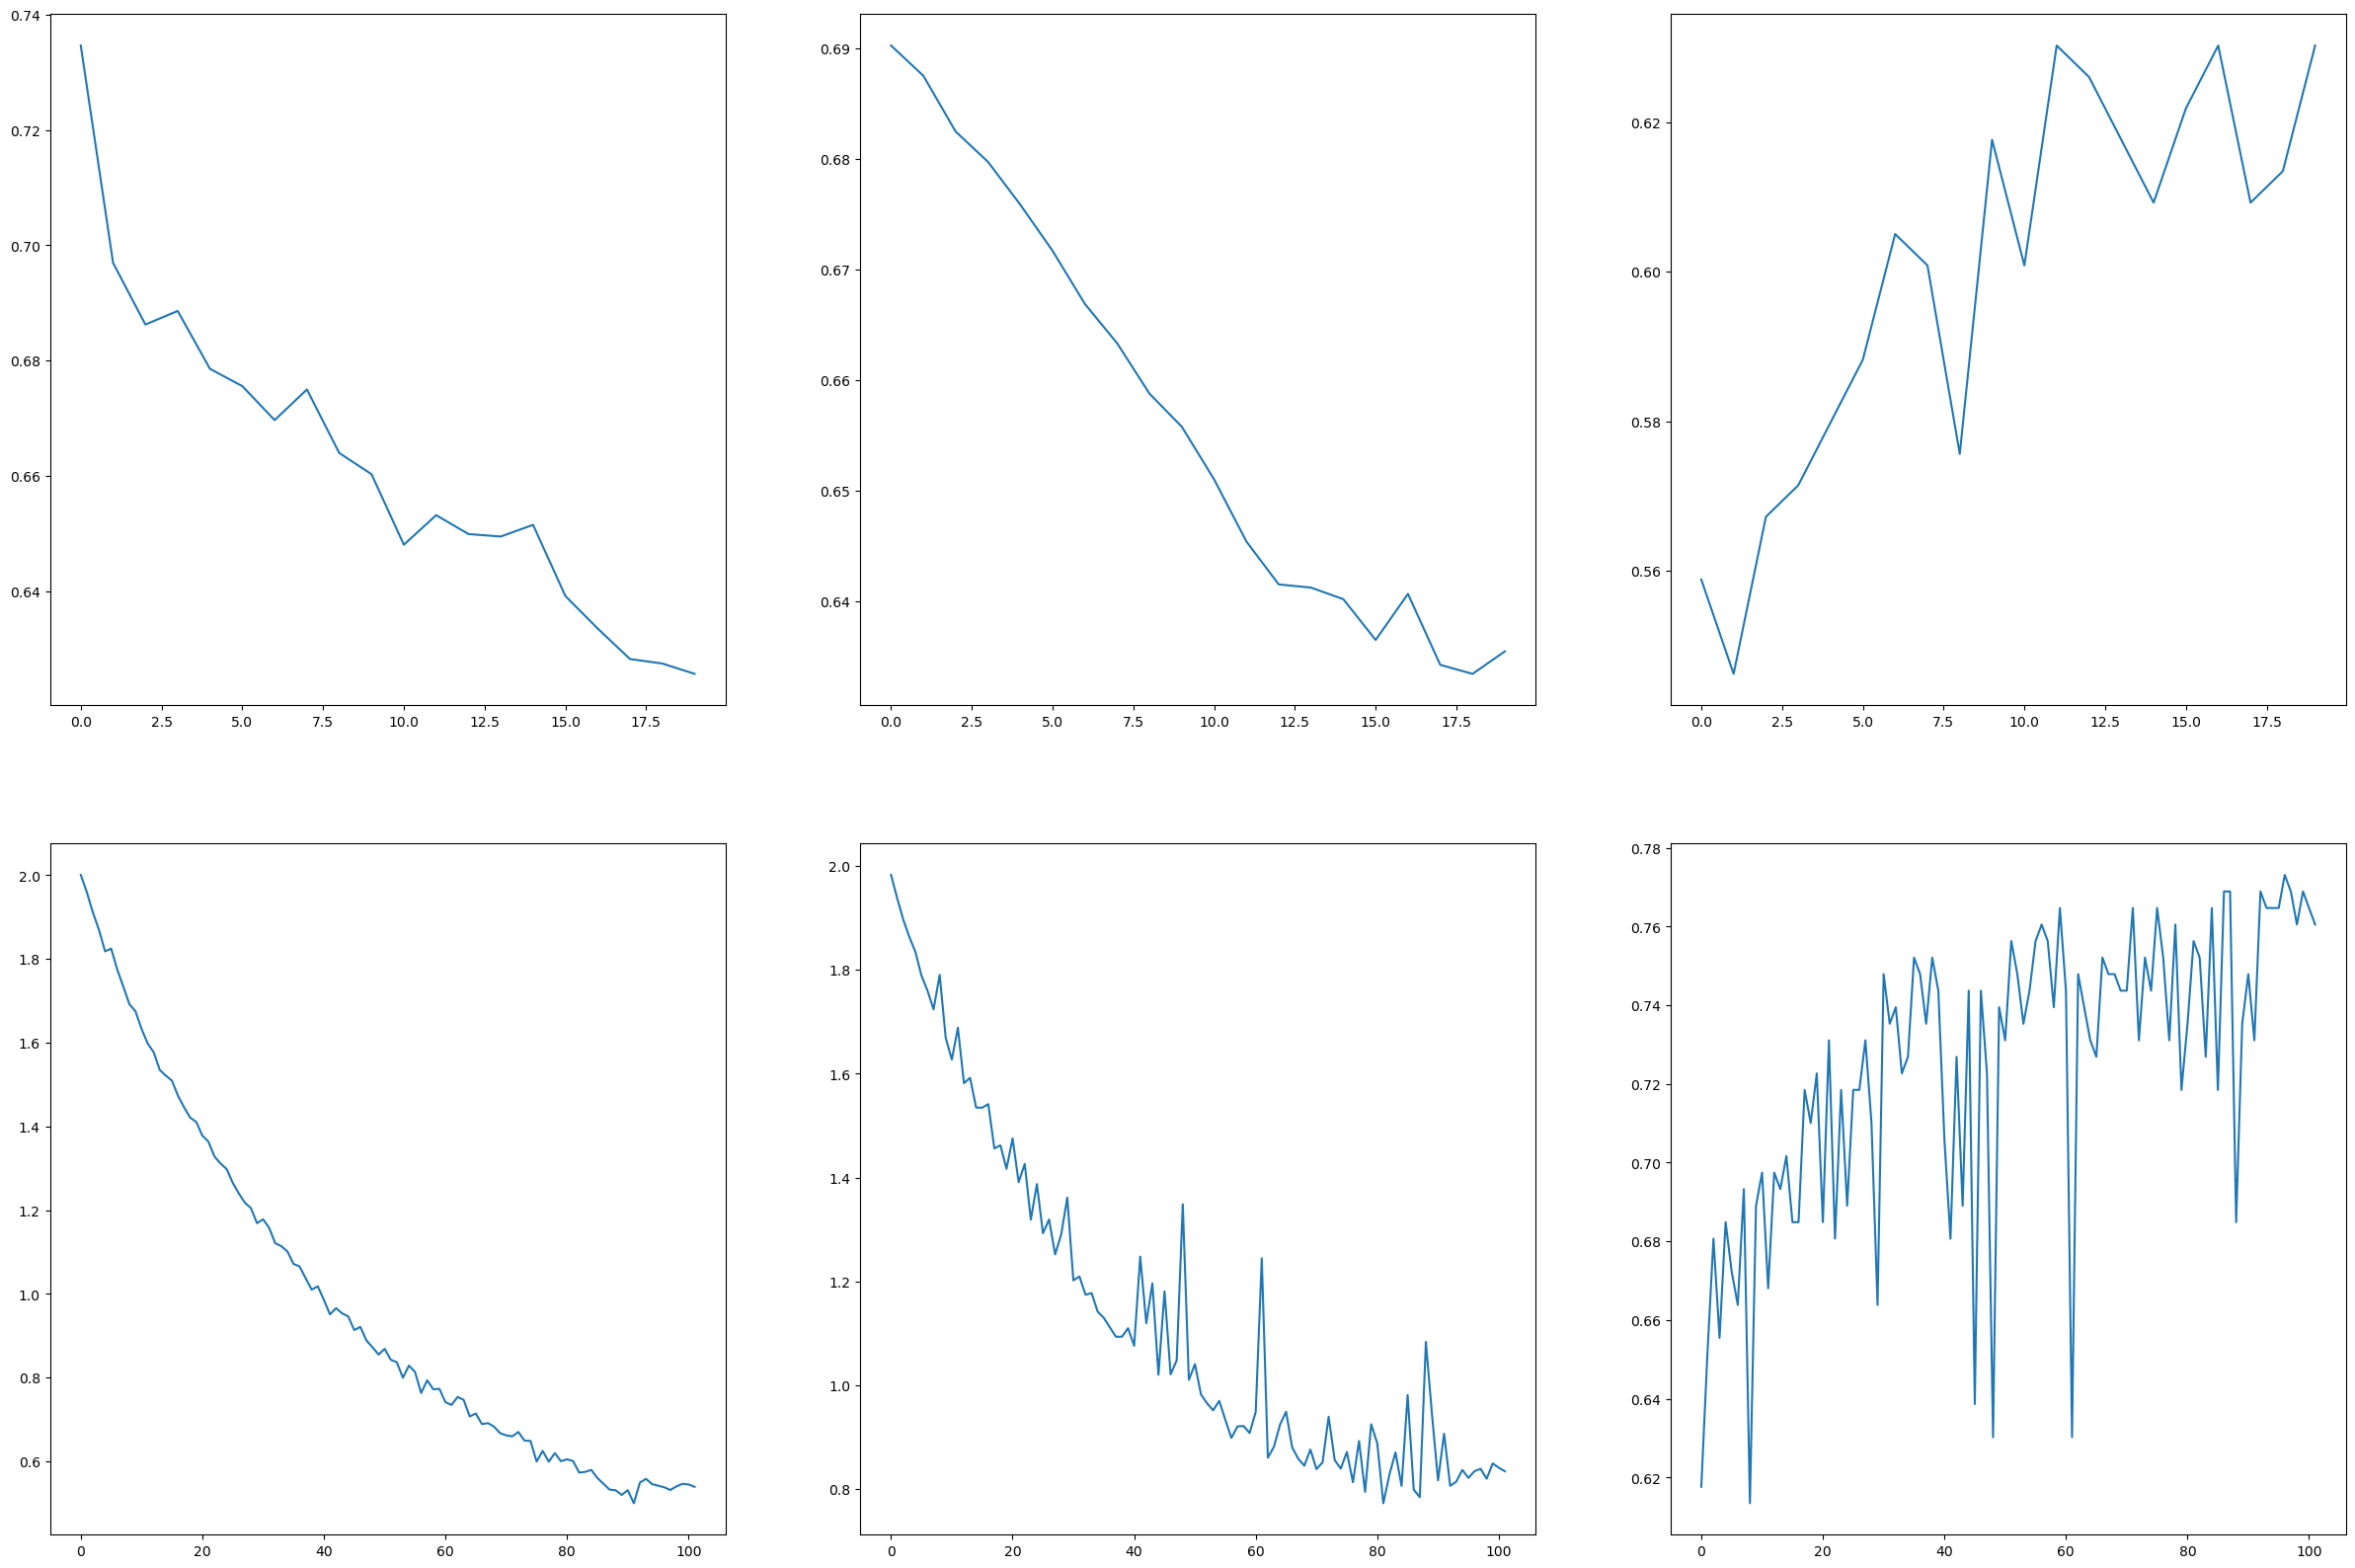

In [9]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(effnet_dense_history['train_loss'])
plt.subplot(232)
plt.plot(effnet_dense_history['val_loss'])
plt.subplot(233)
plt.plot(effnet_dense_history['val_acc'])
plt.subplot(234)
plt.plot(effnet_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(effnet_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(effnet_fine_tune_history['val_acc'])

## Test

In [11]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

23/23 [==============================] - 2s 39ms/step - loss: 0.8184 - categorical_accuracy: 0.7238 - recall_2: 0.7610 - recall_3: 0.6752


# ConvNext

In [31]:
weights = '/home/jj/FYP/Checkpoint/Convnext_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Convnext_CBIS_DDSM/'
model, convnext_dense_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs=20,
    patience=4,
    Earlystop=False,
    augmentation = True,
    trainable_layers = False,
    regulariser=False,
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 8)                 663560    
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0     

KeyboardInterrupt: 

## Fine Tune

In [ ]:
model, convnext_fine_tune_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs=300,
    patience=10,
    Earlystop=50,
    augmentation = True,
    # Top 25 layers are the stage 3 blocks
    trainable_layers = 25,
    regulariser=tf.keras.regularizers.l2(0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-3,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=300,img_width=300)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 flatten_1 (Flatten)         (None, 82944)             0         
                                                                 
 dense_4 (Dense)             (None, 8)                 663560    
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0   

## Figures

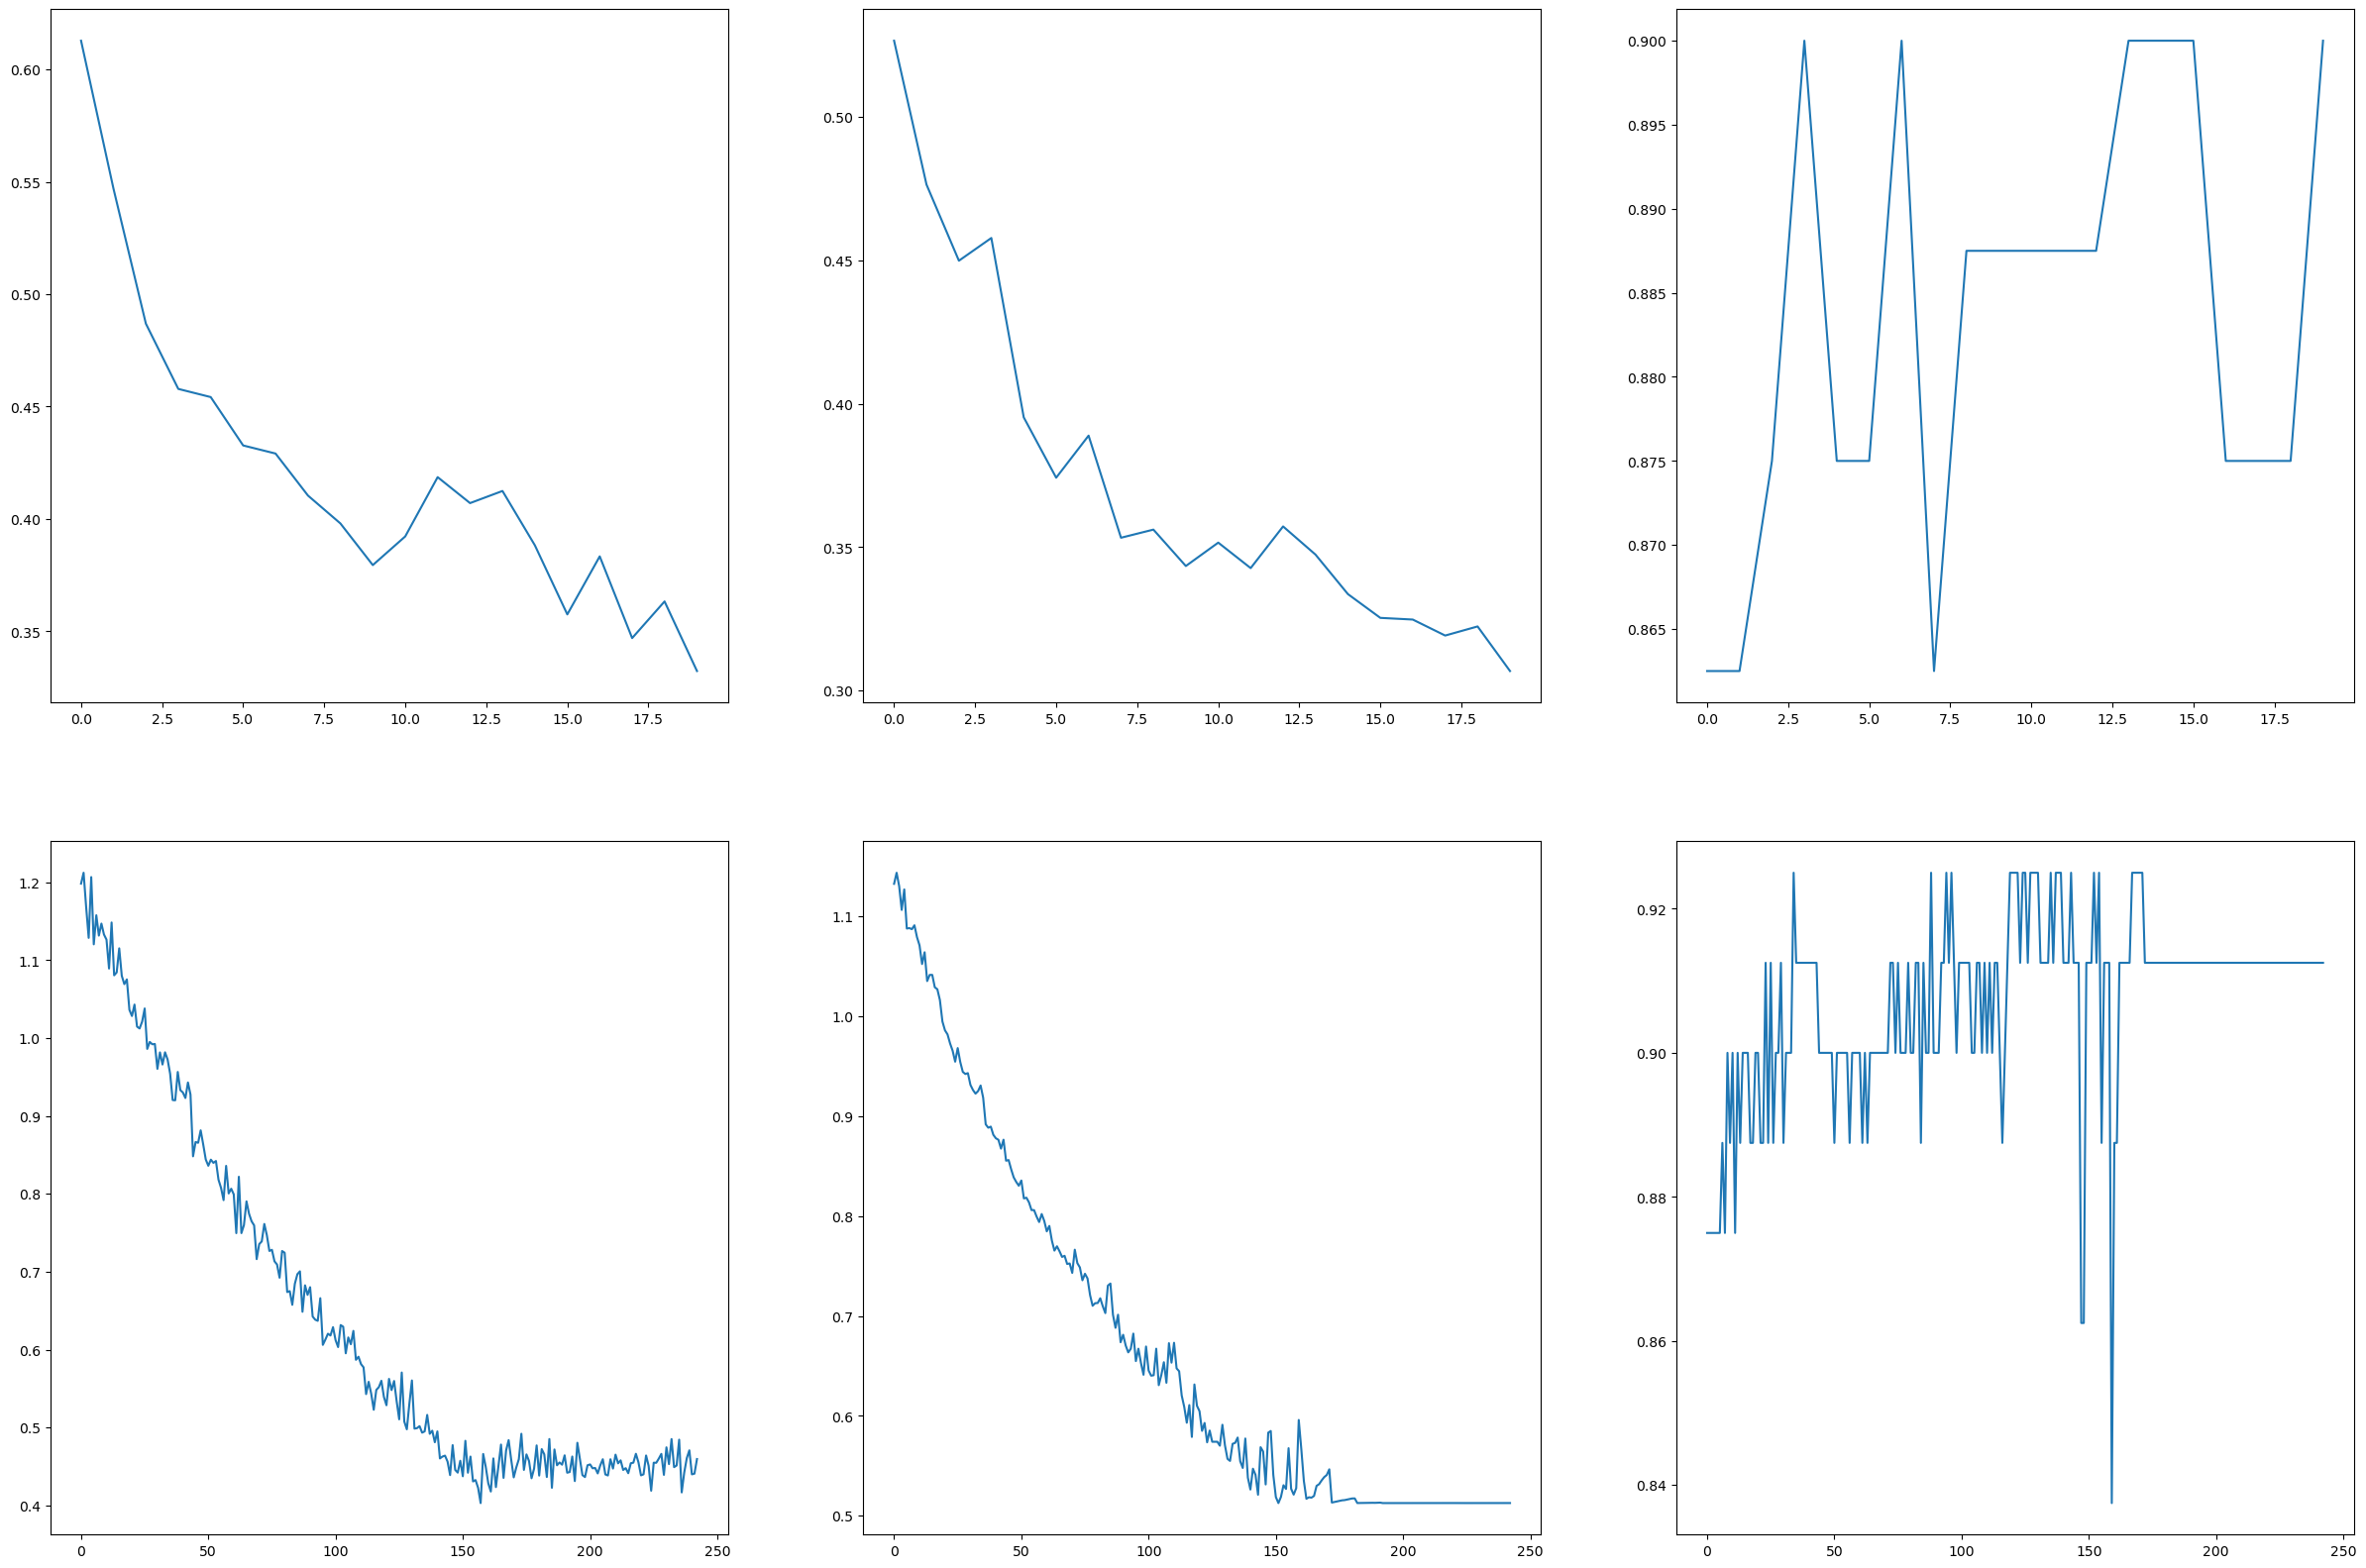

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.plot(convnext_dense_history['train_loss'])
plt.subplot(232)
plt.plot(convnext_dense_history['val_loss'])
plt.subplot(233)
plt.plot(convnext_dense_history['val_acc'])
plt.subplot(234)
plt.plot(convnext_fine_tune_history['train_loss'])
plt.subplot(235)
plt.plot(convnext_fine_tune_history['val_loss'])
plt.subplot(236)
plt.plot(convnext_fine_tune_history['val_acc'])

## Test

In [ ]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
tf.keras.backend.clear_session()

5/5 [==============================] - 3s 669ms/step - loss: 0.5881 - categorical_accuracy: 0.8472 - precision_2: 0.8421 - precision_3: 0.8667
